# Chapter 03

## MNIST

* Scikit-Learn provides many helper functions to download popular datasets. MNIST is
one of them. The following code fetches the MNIST dataset from OpenML.org:1

In [1]:
from sklearn.datasets import fetch_openml

mnist =fetch_openml('mnist_784', as_frame=False)

In [2]:
X,y =mnist.data, mnist.target

In [3]:
X.shape,y.shape

((70000, 784), (70000,))

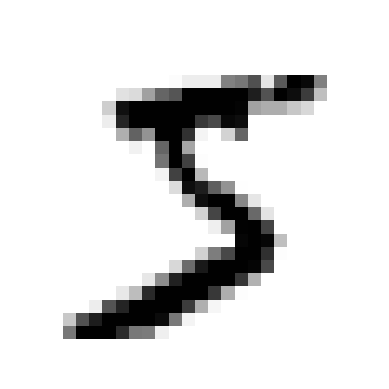

In [4]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image =image_data.reshape(28,28)
    plt.imshow(image,cmap='binary')
    plt.axis('off')

some_digit =X[0]
plot_digit(some_digit)
plt.show()

This looks like a 5, and indeed that’s what the label tells us

In [5]:
y[0]

'5'

In [6]:
X_train,X_test,y_train,y_test =X[:60000],X[60000:], y[:60000],y[60000:]

## Training a Binary Classifier

In [7]:
y_train_5 = (y_train == '5')
y_test_5 =(y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

In [9]:
sgd_clf =SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

,"loss loss: {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}, default='hinge'The loss function to be used.- 'hinge' gives a linear SVM.- 'log_loss' gives logistic regression, a probabilistic classifier.- 'modified_huber' is another smooth loss that brings tolerance to outliers as well as probability estimates.- 'squared_hinge' is like hinge but is quadratically penalized.- 'perceptron' is the linear loss used by the perceptron algorithm.- The other losses, 'squared_error', 'huber', 'epsilon_insensitive' and 'squared_epsilon_insensitive' are designed for regression but can be useful in classification as well; see :class:`~sklearn.linear_model.SGDRegressor` for a description.More details about the losses formulas can be found in the :ref:`User Guide` and you can find a visualisation of the lossfunctions in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_loss_functions.py`.",'hinge'
,"penalty penalty: {'l2', 'l1', 'elasticnet', None}, default='l2'The penalty (aka regularization term) to be used. Defaults to 'l2'which is the standard regularizer for linear SVM models. 'l1' and'elasticnet' might bring sparsity to the model (feature selection)not achievable with 'l2'. No penalty is added when set to `None`.You can see a visualisation of the penalties in:ref:`sphx_glr_auto_examples_linear_model_plot_sgd_penalties.py`.",'l2'
,"alpha alpha: float, default=0.0001Constant that multiplies the regularization term. The higher thevalue, the stronger the regularization. Also used to compute thelearning rate when `learning_rate` is set to 'optimal'.Values must be in the range `[0.0, inf)`.",0.0001
,"l1_ratio l1_ratio: float, default=0.15The Elastic Net mixing parameter, with 0 <= l1_ratio <= 1.l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1.Only used if `penalty` is 'elasticnet'.Values must be in the range `[0.0, 1.0]` or can be `None` if`penalty` is not `elasticnet`... versionchanged:: 1.7 `l1_ratio` can be `None` when `penalty` is not ""elasticnet"".",0.15
,"fit_intercept fit_intercept: bool, default=TrueWhether the intercept should be estimated or not. If False, thedata is assumed to be already centered.",True
,"max_iter max_iter: int, default=1000The maximum number of passes over the training data (aka epochs).It only impacts the behavior in the ``fit`` method, and not the:meth:`partial_fit` method.Values must be in the range `[1, inf)`... versionadded:: 0.19",1000
,"tol tol: float or None, default=1e-3The stopping criterion. If it is not None, training will stopwhen (loss > best_loss - tol) for ``n_iter_no_change`` consecutiveepochs.Convergence is checked against the training loss or thevalidation loss depending on the `early_stopping` parameter.Values must be in the range `[0.0, inf)`... versionadded:: 0.19",0.001
,"shuffle shuffle: bool, default=TrueWhether or not the training data should be shuffled after each epoch.",True
,"verbose verbose: int, default=0The verbosity level.Values must be in the range `[0, inf)`.",0
,"epsilon epsilon: float, default=0.1Epsilon in the epsilon-insensitive loss functions; only if `loss` is'huber', 'epsilon_insensitive', or 'squared_epsilon_insensitive'.For 'huber', determines the threshold at which it becomes lessimportant to get the prediction exactly right.For epsilon-insensitive, any differences between the current predictionand the correct label are ignored if they are less than this threshold.Values must be in the range `[0.0, inf)`.",0.1
,"n_jobs n_jobs: int, default=NoneThe number of CPUs to use to do the OVA (One Versus All, formulti-class problems) computation.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",None


In [10]:
# Now we can use it to detect images of the number 5:

sgd_clf.predict([some_digit])

array([ True])

## `Performance Measures`

Evaluating a classifier is often significantly trickier than evaluating a regressor, so we
will spend a large part of this chapter on this topic. There are many performance
measures available, so grab another coffee and get ready to learn a bunch of new
concepts and acronyms

`Measuring Accuracy Using Cross-Validation`

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3 ,scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

* Make dummy classifier

In [12]:
from sklearn.dummy import DummyClassifier

dummy_clf =DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [13]:
# Can you guess thise models accuracy? lets find out:

cross_val_score(dummy_clf, X_train,y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

`Implimenting Cross-Validation`

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds =StratifiedKFold(n_splits=3)  # add shuffle=True if the datasets is not alredy shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf =clone(sgd_clf)
    X_train_folds =X_train[train_index]
    y_train_folds =y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred =clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred ==y_test_fold)

    print(n_correct /len(y_pred))




0.95035
0.96035
0.9604


`Confusion Matrix`

In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred =cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Now you are ready to get the confusion matrix using the confusion_matrix()
function. Just pass it the target classes (y_train_5) and the predicted classes
(y_train_pred)

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5,y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions =y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

* The confusion matrix gives you a lot of information, but sometimes you may prefer
a more concise metric. An interesting one to look at is the accuracy of the positive
predictions; this is called the precision of the classifi

Equation 3-1. Precision

precision = TP/TP + FP

* Recall

recall = TP/Tp + FN

`Precision and Recall`

In [18]:
# Scikit-Learn provides several functions to compute classfier metrics, including precision and recall

from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5,y_train_pred)

recall_score(y_train_5, y_train_pred)

0.6511713705958311

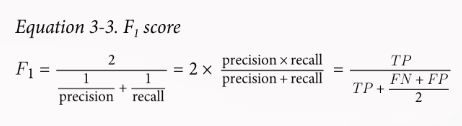

In [19]:
# To compute the F1 score, simply call the f1_score function

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343847

`The Precision/Recall Trade-Off`

Instead of calling the classifier’s predict() method, you can call its decision_func
tion() method, which returns a score for each instance. You can then use any
threshold you want to make predictions based on those scor

In [20]:
y_scores =sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshhold =0
y_some_digit_pred = (y_scores > threshhold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the
same result as the predict() method (i.e., True). Let’s raise the threshold

In [22]:
threshhold = 3000

y_some_digit_pred =(y_scores > threshhold)
y_some_digit_pred

array([False])

In [23]:
y_scores =cross_val_predict(sgd_clf, X_train,y_train_5, cv=3, method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision
and recall for all possible thresholds (the function adds a last precision of 1 and a last
recall of 0, corresponding to an infinite threshold):

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, threshhold =precision_recall_curve(y_train_5,y_scores)

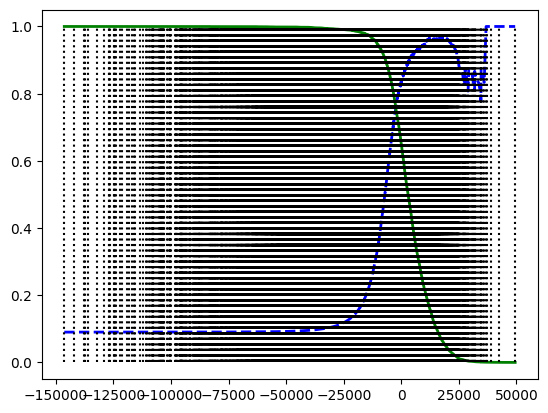

In [25]:
plt.plot(threshhold, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(threshhold, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshhold, 0, 1.0, "k", "dotted", label="threshold")
[...]
plt.show()

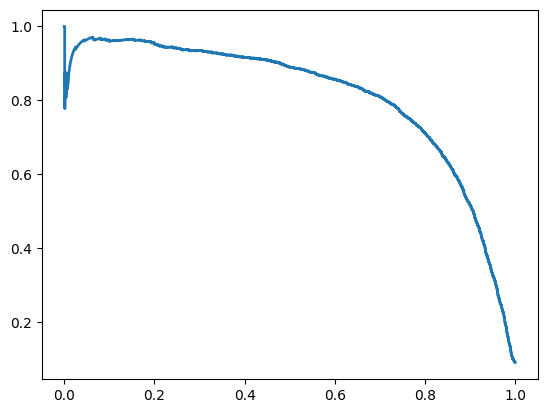

In [26]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
[...]
plt.show()

NumPy array’s argmax() method. This returns the first index of the maximum value,
which in this case means the first True value:

In [27]:
idx_for_90_precision = (precisions >=0.90).argmax()
threshold_for_90_precision =threshhold[idx_for_90_precision]
threshold_for_90_precision

np.float64(3370.0194991439557)

To make predictions (on the training set for now), instead of calling the classifier’s
predict() method, you can run this code:

In [28]:
y_train_pred_90 =(y_scores >=threshold_for_90_precision)

Let's check these predictions precison and recall

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

## The ROC Curve

* To plot the ROC curve, you first use the roc_curve() function to compute the TPR
and FPR for various threshold values:

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds =roc_curve(y_train_5, y_scores)

In [32]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()

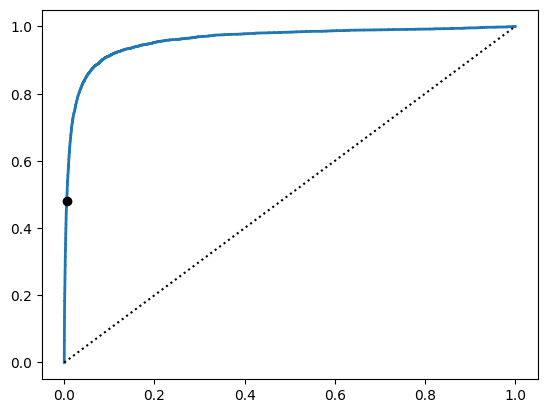

In [33]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
[...] # beautify the figure: add labels, grid, legend, arrow, and text
plt.show()

In [34]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can
compare to those of the SGDClassifi

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_clf =RandomForestClassifier(random_state=42)

We can call the cross_val_predict() function to train the RandomForestClassifier using cross-validation and make it predict class probabilities for every image as follow:

In [37]:
y_probas_forest =cross_val_predict(forest_clf, X_train,y_train_5, cv=3, method='predict_proba')

Let’s look at the estimated class probabilities for the first two images in the training
set:

In [38]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The second column contains the estimated probabilities for the positive class, so let’s
pass them to the precision_recall_curve() functio

In [39]:
y_scores_forest = y_probas_forest[:, 1]
precision_forest, recalls_forest, threshold_forest =precision_recall_curve(y_train_5, y_scores_forest)

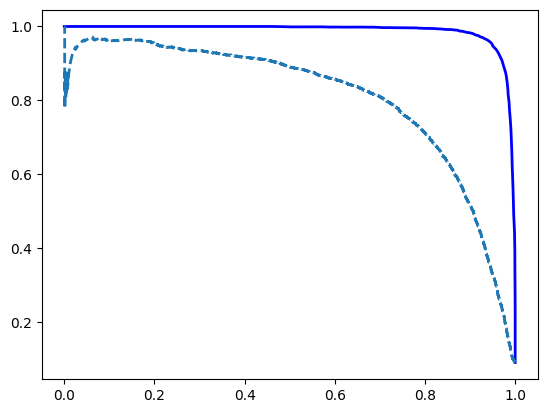

In [40]:
plt.plot(recalls_forest, precision_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
[...]
plt.show()

In [41]:
y_train_pred_forest =y_probas_forest[:, 1] >=0.5
f1_score(y_train_5, y_train_pred_forest)

roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

In [42]:
from sklearn.svm import SVC

svm_clf =SVC(random_state=42)
svm_clf.fit(X_train[:2000],y_train[:2000]) # y_train, not y_train_5

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [43]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

In [44]:
some_digit_scores =svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5:

In [45]:
class_id =some_digit_scores.argmax()
class_id

np.int64(5)

In [47]:
svm_clf.classes_
svm_clf.classes_[class_id]

'5'

In [48]:
# Thise code creates a multiclass classifier using the OvR
# stategy, based on an SVC:

from sklearn.multiclass import OneVsRestClassifier

ovr_clf =OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

,"estimator estimator: estimator objectA regressor or a classifier that implements :term:`fit`.When a classifier is passed, :term:`decision_function` will be usedin priority and it will fallback to :term:`predict_proba` if it is notavailable.When a regressor is passed, :term:`predict` is used.",SVC(random_state=42)
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation: the `n_classes`one-vs-rest problems are computed in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: 0.20 `n_jobs` default changed from 1 to None",None
,"verbose verbose: int, default=0The verbosity level, if non zero, progress messages are printed.Below 50, the output is sent to stderr. Otherwise, the output is sentto stdout. The frequency of the messages increases with the verbositylevel, reporting all iterations at 10. See :class:`joblib.Parallel` formore details... versionadded:: 1.1",0
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001


In [49]:
# Lets make a prediction and check the number of trained classifier:

ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [50]:
len(ovr_clf.estimators_)

10

In [51]:
# Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:

sgd_clf =SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

In [52]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -19047.55566534,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87745, 0.85835, 0.8698 ])

In [54]:
from sklearn.preprocessing import StandardScaler

scaler =StandardScaler()
X_train_scaled =scaler.fit_transform(X_train.astype('float64'))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


array([0.89835, 0.8902 , 0.90095])

# Error Analysis

A colored diagram of the confusion matrix is much easier to analyze. To plot such a
diagram, use the ConfusionMatrixDisplay.from_predictions() function like this:

/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/kshitij/Desktop/Learn_Along_Agentic-AI/.venv/lib/python3.13/site-packages/sklearn/linear_model/_stochastic_gradient.py:733: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


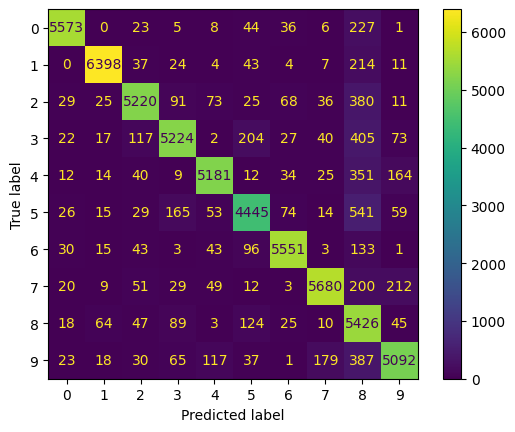

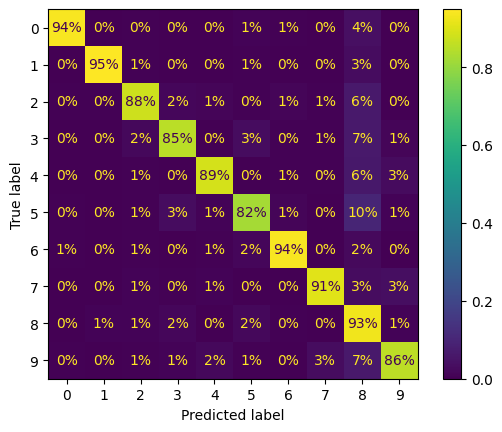

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred =cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)

plt.show()

ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred, normalize='true', values_format=".0%")
plt.show()

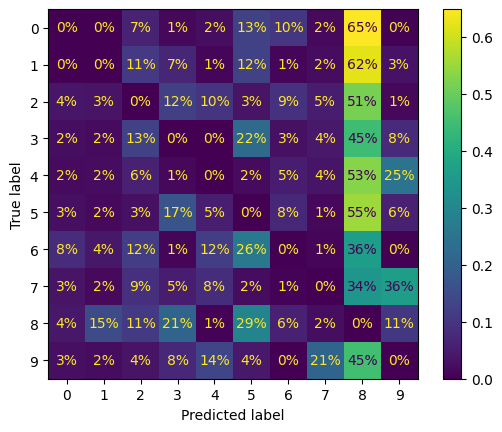

In [56]:
sample_weight =(y_train_pred !=y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")

# Multilabel Classification

In [57]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2==1)
y_multilabel =np.c_[y_train_large, y_train_odd]

knn_clf =KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

,"n_neighbors n_neighbors: int, default=5Number of neighbors to use by default for :meth:`kneighbors` queries.",5
,"weights weights: {'uniform', 'distance'}, callable or None, default='uniform'Weight function used in prediction. Possible values:- 'uniform' : uniform weights. All points in each neighborhood are weighted equally.- 'distance' : weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.- [callable] : a user-defined function which accepts an array of distances, and returns an array of the same shape containing the weights.Refer to the example entitled:ref:`sphx_glr_auto_examples_neighbors_plot_classification.py`showing the impact of the `weights` parameter on the decisionboundary.",'uniform'
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'Algorithm used to compute the nearest neighbors:- 'ball_tree' will use :class:`BallTree`- 'kd_tree' will use :class:`KDTree`- 'brute' will use a brute-force search.- 'auto' will attempt to decide the most appropriate algorithm based on the values passed to :meth:`fit` method.Note: fitting on sparse input will override the setting ofthis parameter, using brute force.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or KDTree. This can affect thespeed of the construction and query, as well as the memoryrequired to store the tree. The optimal value depends on thenature of the problem.",30
,"p p: float, default=2Power parameter for the Minkowski metric. When p = 1, this is equivalentto using manhattan_distance (l1), and euclidean_distance (l2) for p = 2.For arbitrary p, minkowski_distance (l_p) is used. This parameter is expectedto be positive.",2
,"metric metric: str or callable, default='minkowski'Metric to use for distance computation. Default is ""minkowski"", whichresults in the standard Euclidean distance when p = 2. See thedocumentation of `scipy.spatial.distance`_ andthe metrics listed in:class:`~sklearn.metrics.pairwise.distance_metrics` for valid metricvalues.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square during fit. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors.If metric is a callable function, it takes two arrays representing 1Dvectors as inputs and must return one value indicating the distancebetween those vectors. This works for Scipy's metrics, but is lessefficient than passing the metric name as a string.",'minkowski'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run for neighbors search.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.Doesn't affect :meth:`fit` method.",None


In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:

y_train_knn_pred =cross_val_predict(knn_clf, X_train,y_multilabel,cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

how to create and train a ClassifierChain using the cross-validation strategy. As
earlier, we’ll just use the first 2,000 images in the training set to speed things up

In [60]:
from sklearn.multioutput import ClassifierChain

chain_clf=ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

,estimator estimator: estimatorThe base estimator from which the classifier chain is built.,SVC()
,"order order: array-like of shape (n_outputs,) or 'random', default=NoneIf `None`, the order will be determined by the order of columns inthe label matrix Y.:: order = [0, 1, 2, ..., Y.shape[1] - 1]The order of the chain can be explicitly set by providing a list ofintegers. For example, for a chain of length 5.:: order = [1, 3, 2, 4, 0]means that the first model in the chain will make predictions forcolumn 1 in the Y matrix, the second model will make predictionsfor column 3, etc.If order is `random` a random ordering will be used.",None
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines whether to use cross validated predictions or truelabels for the results of previous estimators in the chain.Possible inputs for cv are:- None, to use true labels when fitting,- integer, to specify the number of folds in a (Stratified)KFold,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.",3
,"chain_method chain_method: {'predict', 'predict_proba', 'predict_log_proba', 'decision_function'} or list of such str's, default='predict'Prediction method to be used by estimators in the chain forthe 'prediction' features of previous estimators in the chain.- if `str`, name of the method;- if a list of `str`, provides the method names in order of preference. The method used corresponds to the first method in the list that is implemented by `base_estimator`... versionadded:: 1.5",'predict'
,"random_state random_state: int, RandomState instance or None, optional (default=None)If ``order='random'``, determines random number generation for thechain order.In addition, it controls the random seed given at each `base_estimator`at each chaining iteration. Thus, it is only used when `base_estimator`exposes a `random_state`.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: bool, default=FalseIf True, chain progress is output as each model is completed... versionadded:: 1.2",False
,"base_estimator base_estimator: estimator, default=""deprecated""Use `estimator` instead... deprecated:: 1.7 `base_estimator` is deprecated and will be removed in 1.9. Use `estimator` instead.",'deprecated'
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


# Multioutput CLassification

In [64]:
rng =np.random.default_rng(seed=42)
noise_train =rng.integers(0, 100, (len(X_train), 784))
X_train_mod =X_train + noise_train
noise_test =rng.integers(0, 100, (len(X_test), 784))
X_test_mod =X_test + noise_test
y_train_mod =X_train
y_test_mod =X_test


On the left is the noisy input image, and on the right is the clean target image. Now
let’s train the classifier and make it clean up this ima

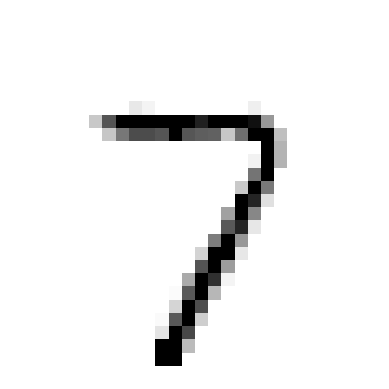

In [65]:
knn_clf =KNeighborsClassifier()
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit =knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()